In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score
from scipy.stats import beta
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts

In [2]:
figure_outdir = 'figures'
os.makedirs(figure_outdir, exist_ok=True)

Lund_clinical_dir = os.path.join(consts['official_indir'], 'Lund')
Lund_c_beta_dir = os.path.join(consts['repo_dir'], 'Process_Other_Data_Sources', 'outputs', 'Lund')
beta_peak_indir = os.path.join(consts['official_indir'], 'Beta Peak Decomposition')

In [5]:
clinical = {}

clinical['TCGA'] = pd.read_table(os.path.join(consts['TCGA_datadir'], 'TCGA.clinical.annotated.tsv'), index_col=0)
clinical['Lund'] = pd.read_table(os.path.join(Lund_clinical_dir, 'Lund.clinical.txt'), index_col=0, dtype={'grade':str})
clinical['Lund']['c_beta'] = pd.read_table(os.path.join(Lund_c_beta_dir, 'Lund.c_beta.txt'), index_col=0).squeeze("columns")
clinical['Lund']['spf'] = clinical['Lund']['spfPercent'] / 100
clinical['Lund']['log_spf'] = np.log(clinical['Lund']['spf'])

subtype_list = ['LumA', 'LumB', 'Her2', 'Basal']

clinical['TCGA']['subtype'] = clinical['TCGA']['subtype.pam50']
clinical['Lund']['subtype'] = clinical['Lund']['genefu.pam50.subtype']

In [6]:
for dataset in clinical:
    print(dataset)
    modes = pd.read_csv(os.path.join(beta_peak_indir, dataset, 'readable_tables','modes.txt'), sep=' ')
    
    if dataset == 'TCGA':
        modes = modes.rename(index=epi_util.sampleToPatientID)
    
    clinical[dataset]['beta_A'] = modes.apply(lambda x: np.sort(x)[0], axis=1)
    clinical[dataset]['beta_middle'] = modes.apply(lambda x: np.sort(x)[1], axis=1)
    clinical[dataset]['beta_B'] = modes.apply(lambda x: np.sort(x)[2], axis=1)

    # Estimates using left and right peak
    clinical[dataset]['avg_n_flips_estA'] = -np.log(1 - 2 * clinical[dataset]['beta_A']) / 2
    clinical[dataset]['avg_n_flips_estB'] = -np.log(2 * clinical[dataset]['beta_B'] - 1) / 2
    
    # Use the average of the two estimates
    clinical[dataset]['avg_n_flips'] = (clinical[dataset]['avg_n_flips_estA'] + clinical[dataset]['avg_n_flips_estB']) / 2
    
    clinical[dataset] = clinical[dataset].loc[clinical[dataset]['in_analysis_dataset'] & (clinical[dataset]['subtype'] != 'Normal') & ~clinical[dataset]['c_beta'].isna()]
    
#     print('here')
#     print(clinical[dataset].index.values.shape)
#     np.savetxt(f'/Users/danielmonyak/Desktop/used_in_beta_models-{dataset}.txt', clinical[dataset].index.values, fmt='%s')
    
#     print(clinical[dataset].shape)
#     before = clinical[dataset].shape[0]
    clinical[dataset] = clinical[dataset].loc[(clinical[dataset]['beta_middle'] >= 0.4) & (clinical[dataset]['beta_middle'] <= 0.6)]
#     print(clinical[dataset].shape)
#     after = clinical[dataset].shape[0]
    
#     print(before - after)


TCGA
Ringner


In [7]:
def c_beta_to_n_flips(c_beta):
    return -np.log(2 * np.sqrt(2) * (1-c_beta))/2

0.2965464459853949
0.23788901961854447


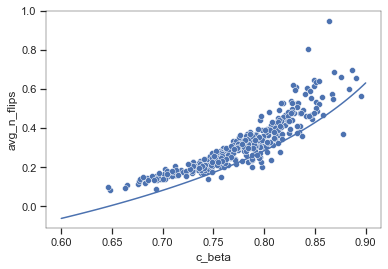

In [290]:
x_arr = np.linspace(0.6, 0.9, 100)
sns.scatterplot(data=clinical['TCGA'], x='c_beta', y='avg_n_flips')
plt.plot(x_arr, c_beta_to_n_flips(x_arr))

print(clinical['TCGA']['avg_n_flips'].median())
print(c_beta_to_n_flips(clinical['TCGA']['c_beta']).median())

In [291]:
c_beta_adj1 = pd.read_table(os.path.join(consts['TCGA_datadir'], 'c_beta_adj1.tsv')).T.rename(index=epi_util.getSampleID).squeeze('columns').rename('c_beta_adj1')
clinical['TCGA'] = clinical['TCGA'].merge(c_beta_adj1, left_on='sampleID', right_index=True)

0.10397767907701641


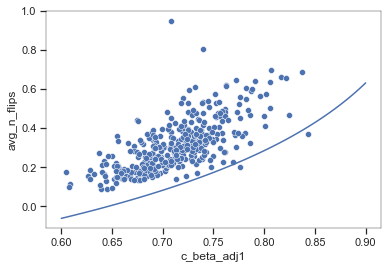

In [292]:
x_arr = np.linspace(0.6, 0.9, 100)
sns.scatterplot(data=clinical['TCGA'], x='c_beta_adj1', y='avg_n_flips')
plt.plot(x_arr, c_beta_to_n_flips(x_arr))

print(c_beta_to_n_flips(clinical['TCGA']['c_beta_adj1']).median())

<Axes: xlabel='c_beta', ylabel='c_beta_adj1'>

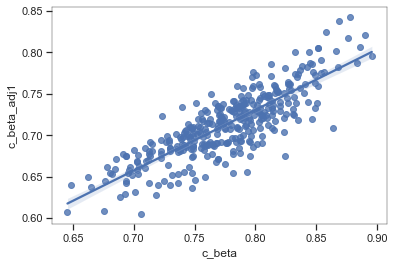

In [293]:
sns.regplot(data=clinical['TCGA'], x='c_beta', y='c_beta_adj1')

In [294]:
c_beta_adj1
# clinical['TCGA'].merge

TCGA-E2-A1B1-01A    0.837522
TCGA-AN-A0XO-01A    0.721989
TCGA-AR-A255-01A    0.739239
TCGA-UL-AAZ6-01A    0.608996
TCGA-LD-A7W5-01A    0.776487
                      ...   
TCGA-A2-A04R-01A    0.681847
TCGA-D8-A1XW-01A    0.679160
TCGA-E2-A1AZ-01A    0.692157
TCGA-C8-A26V-01A    0.723864
TCGA-AR-A0TP-01A    0.649687
Name: c_beta_adj1, Length: 400, dtype: float64

In [8]:
# Configure graph
sf = consts['sf']
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

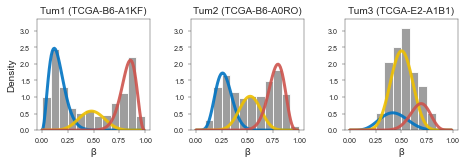

In [9]:
patient_list = {'Tum1':'TCGA-B6-A1KF',
               'Tum2':'TCGA-B6-A0RO',
               'Tum3':'TCGA-E2-A1B1'}

fig, axes = plt.subplots(1, len(patient_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=0.2)

beta_values_balancedSites_TCGA = pd.read_table(os.path.join(consts['TCGA_datadir'], 'TCGA.methyl.balancedSites.tsv'),
                      index_col=0).rename(columns=epi_util.sampleToPatientID)
alpha = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'readable_tables', 'alpha.txt'), sep=' ').rename(index=epi_util.sampleToPatientID)
delta = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'readable_tables', 'delta.txt'), sep=' ').rename(index=epi_util.sampleToPatientID)
phi = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'readable_tables', 'phi.txt'), sep=' ').rename(index=lambda x:epi_util.sampleToPatientID(x.replace('.', '-')))

chosen_tumor_colors = [consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    ax = axes[i]
    
    samp = patient_list[patient]
    cur_color = chosen_tumor_colors[i]
    
    sns.histplot(ax=ax, x=beta_values_balancedSites_TCGA[samp], stat='density',
#                 color=cur_color,
                 color=consts['palette_jco'][2],
                 bins=12, alpha=consts['opacity'],
                binrange=(0, 1))
    
    ax.set_title(f'{patient} ({samp})', fontsize=consts['labelfontsize'] * sf)
    ax.set_xlabel('β', fontsize=consts['labelfontsize'] * sf)
    if i == 0:
        ax.set_ylabel('Density', fontsize=consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    frac_list = phi.loc[samp]
    
    y_max = float('-Inf')
    
    for j, model in enumerate(alpha.columns):
        
        a = alpha.loc[samp, model]
        d = delta.loc[samp, model]

        x = np.linspace(0, 0.99, 100)
        y = beta.pdf(x, a, d) * frac_list[j]
        ax.plot(x, y, lw=3, alpha=0.9,
                color=chosen_tumor_colors[j]
               )
        
        y_max = max(y_max, ax.get_ylim()[1])

for i in range(len(patient_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

In [10]:
predictors = [
    'Stroma', 'Lipid', 'IR', 'Mitotic Checkpoint', 'Mitotic Progression', 'Basal', 'Early Response', 'SR',
    'FGA', 'LUMP'
]

response = 'log_spf'

train_data = clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], predictors + [response]].dropna()
train_X = train_data[predictors]
train_y = train_data[response]

TCGA_X = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], predictors].dropna()

In [11]:
eNetCV = ElasticNetCV(alphas=np.linspace(0.01, 0.99, 20), l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
eNetCV.fit(train_X, train_y)

print(f'alpha = {eNetCV.alpha_}')
print(f'l1 ratio = {eNetCV.l1_ratio_}')

y_pred = eNetCV.predict(train_X)
r2 = r2_score(train_y, y_pred)
print(f'R^2 = {r2:.2f}')

alpha = 0.01
l1 ratio = 0.1
R^2 = 0.71


In [12]:
clinical['TCGA'].loc[TCGA_X.index, response] = eNetCV.predict(TCGA_X)
clinical['TCGA']['spf'] = np.exp(clinical['TCGA']['log_spf'])

s_phase_duration_hrs = np.mean([12.40, 11.70, 13.60, 12.95, 12.66])
s_phase_duration = s_phase_duration_hrs / 24

# Growth rate with 1 day as time unit
for dataset in clinical:
    clinical[dataset]['growth_rate'] = clinical[dataset]['spf'] / s_phase_duration
    clinical[dataset]['calendar_age_prod_flip_rate'] = clinical[dataset]['avg_n_flips'] / clinical[dataset]['growth_rate']

In [13]:
## Flip rate

flip_rate_TCGA = clinical['TCGA']['calendar_age_prod_flip_rate'].median() / (3 * 365)
flip_rate_Lund = clinical['Lund']['calendar_age_prod_flip_rate'].median() / (3 * 365)

print(f'TCGA-predicted flip rate: {flip_rate_TCGA:.4f}')
print(f'Lund-predicted flip rate: {flip_rate_Lund:.4f}')

TCGA-predicted flip rate: 0.0022
Lund-predicted flip rate: 0.0022


In [14]:
# combined

combined_intermed_df = pd.concat(
    [
        clinical['TCGA'][['in_analysis_dataset', 'calendar_age_prod_flip_rate', 'growth_rate']],
        clinical['Lund'][['in_analysis_dataset', 'calendar_age_prod_flip_rate', 'growth_rate']]
    ],
    axis=0)
flip_rate_est = combined_intermed_df.loc[combined_intermed_df['in_analysis_dataset'],
                                         'calendar_age_prod_flip_rate'].median() / (3 * 365)
flip_rate_est

0.002179851975932616

In [15]:
print('TCGA')
print(np.mean(1 / clinical['TCGA']['growth_rate']))
print(1 / np.mean(clinical['TCGA']['growth_rate']))
print()
print('Lund')
print(np.mean(1 / clinical['Lund']['growth_rate']))
print(1 / np.mean(clinical['Lund']['growth_rate']))
print()
print('Combined')
print(np.mean(1 / combined_intermed_df['growth_rate']))
print(1 / np.mean(combined_intermed_df['growth_rate']))

TCGA
10.388668983627541
6.123914612990274

Ringner
8.325837030145147
5.173099940155596

Combined
10.027927435112147
5.933207514088846


In [16]:
print(np.mean(combined_intermed_df['growth_rate']))

0.16854289987758309


In [17]:
flip_rate_est_per_year = np.mean(flip_rate_est * combined_intermed_df['growth_rate'] * 365)
print(f'# flips / year: {flip_rate_est_per_year:.2f}')

# flips / year: 0.13


<Axes: xlabel='growth_rate', ylabel='Count'>

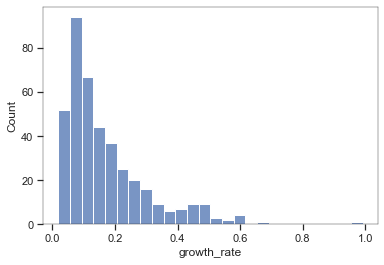

In [18]:
sns.histplot(combined_intermed_df['growth_rate'])

In [19]:
for dataset in clinical:
    clinical[dataset]['mitotic_age'] = clinical[dataset]['avg_n_flips'] / flip_rate_est
    clinical[dataset]['calendar_age_years'] = clinical[dataset]['calendar_age_prod_flip_rate'] / flip_rate_est / 365

In [20]:
clinical['TCGA']['in_analysis_dataset'].sum()

353

In [21]:
clinical['Lund']['in_analysis_dataset'].sum()

79

In [22]:
combined_calendar = pd.concat(
    [
        clinical['TCGA'][['in_analysis_dataset', 'calendar_age_years']],
        clinical['Lund'][['in_analysis_dataset', 'calendar_age_years']]
    ],
    axis=0)
combined_calendar.loc[combined_calendar['in_analysis_dataset'], 'calendar_age_years'].describe()

count    406.000000
mean       4.344112
std        4.230011
min        0.209038
25%        1.547257
50%        3.000000
75%        5.600612
max       35.200758
Name: calendar_age_years, dtype: float64

Wilcoxon rank-sums p-values:


,LumA,LumB,Her2,Basal
LumA,NaN,1.302011e-25,5.794480e-13,1.147616e-28
LumB,NaN,NaN,2.375815e-02,7.434044e-20
Her2,NaN,NaN,NaN,8.314771e-08
Basal,NaN,NaN,NaN,NaN


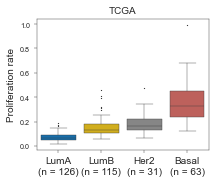

In [45]:
clinical['TCGA'].name = 'TCGA'
epi_util.saveBoxPlotNew(clinical['TCGA'], 'subtype.pam50', restrict=True,
                   var_y='growth_rate', ylabel='Proliferation rate',
                   outdir='figures', title=True, use_groups=subtype_list,
                   palette=consts['palette_jco'], signif_bar_heights=None,
                   figsize=figsize * [1.1, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

pvalue_tbl = epi_util.getWilcoxonPvalueTable(clinical['TCGA'], 'subtype.pam50', 'growth_rate', use_groups=subtype_list)
print('Wilcoxon rank-sums p-values:')
display(pvalue_tbl)

Wilcoxon rank-sums p-values:


,LumA,LumB,Her2,Basal
LumA,NaN,0.003089,0.000010,0.000002
LumB,NaN,NaN,0.029295,0.005706
Her2,NaN,NaN,NaN,0.435599
Basal,NaN,NaN,NaN,NaN


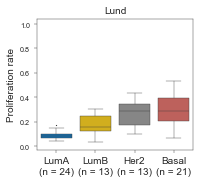

In [46]:
clinical['Lund'].name = 'Lund'
epi_util.saveBoxPlotNew(clinical['Lund'], 'genefu.pam50.subtype', restrict=True,
                   var_y='growth_rate', ylabel='Proliferation rate',
                   outdir='figures', title=True, use_groups = subtype_list,
                   palette=consts['palette_jco'], ylim=(-0.03, 1.04), signif_bar_heights=None,
                   figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

pvalue_tbl = epi_util.getWilcoxonPvalueTable(clinical['Lund'], 'genefu.pam50.subtype', 'growth_rate', use_groups=subtype_list)
print('Wilcoxon rank-sums p-values:')
display(pvalue_tbl)

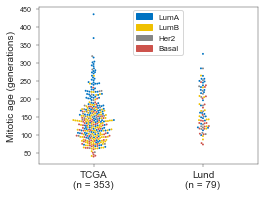

In [312]:
fig, ax = plt.subplots(figsize=figsize * [1.4, 1.2] * sf)

df_ch1 = pd.DataFrame({'mitotic_age':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'mitotic_age'],
                       'Subtype':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'subtype.pam50'],
                       'cohort':'TCGA'}).dropna()
df_ch2 = pd.DataFrame({'mitotic_age':clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], 'mitotic_age'],
                       'Subtype':clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], 'genefu.pam50.subtype'],
                       'cohort':'Lund'}).dropna()
df_combined = pd.concat([df_ch1, df_ch2], axis=0)

color_list = consts['palette_jco'][:4]
color_dict = dict(zip(subtype_list, color_list))

sns.swarmplot(ax=ax, data=df_combined, x='cohort',
              y='mitotic_age',
              hue='Subtype',
              palette=color_dict,
              legend=False,
             s=12 * sf**2)

# ax.set_title(f'~{flip_rate_est:.3f} (de-)methylation events/division/allele', fontsize=consts['labelfontsize'] * sf)
ax.set_xlabel('')
ax.set_ylabel('Mitotic age (generations)', fontsize=consts['labelfontsize'] * sf)

ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["cohort"] == group).sum()})'
                   for group in ['TCGA', 'Lund']])
ax.tick_params(axis='x', labelsize=consts['labelfontsize'] * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(0.65, plots_y + .005),
           fontsize=0.8*consts['labelfontsize'] * sf
          )

fig.savefig(os.path.join(figure_outdir, 'mitotic_age.pdf'), format='pdf', pad_inches=0.1)

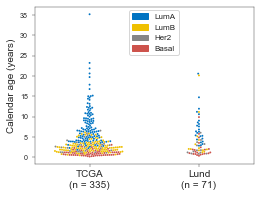

In [313]:
fig, ax = plt.subplots(figsize=figsize * [1.4, 1.2] * sf)

df_ch1 = pd.DataFrame({'calendar_age_years':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'calendar_age_years'],
                       'Subtype':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'subtype.pam50'],
                       'cohort':'TCGA'}).dropna()
df_ch2 = pd.DataFrame({'calendar_age_years':clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], 'calendar_age_years'],
                       'Subtype':clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], 'genefu.pam50.subtype'],
                       'cohort':'Lund'}).dropna()
df_combined = pd.concat([df_ch1, df_ch2], axis=0)

color_list = consts['palette_jco'][:4]
color_dict = dict(zip(subtype_list, color_list))

sns.swarmplot(ax=ax, data=df_combined, x='cohort',
              y='calendar_age_years',
              hue='Subtype',
              palette=color_dict,
              legend=False,
             s=12 * sf**2)
ax.set_xlabel('')
ax.set_ylabel('Calendar age (years)', fontsize=consts['labelfontsize'] * sf)

ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["cohort"] == group).sum()})'
                   for group in ['TCGA', 'Lund']])
ax.tick_params(axis='x', labelsize=consts['labelfontsize'] * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(0.65, plots_y + .005),
           fontsize=0.8*consts['labelfontsize'] * sf
          )

fig.savefig(os.path.join(figure_outdir, 'calendar_age.pdf'), format='pdf', pad_inches=0.1)

In [314]:
def subtypeQuartileSer(sample_annotations, metric, label=None):
    sample_annotations = sample_annotations.loc[sample_annotations['in_analysis_dataset']]
    if label is None:
        label = metric
    
    qrt_func = lambda x:x.quantile([0.25, 0.5, 0.75])
    quartile_df = sample_annotations.groupby('subtype')[metric].apply(qrt_func).unstack().loc[subtype_list]
    quartile_df = pd.concat([quartile_df, sample_annotations[metric].agg(qrt_func).rename('Total').to_frame().T], axis=0)
    quartile_df = np.round(quartile_df, 2)

    quartile_df = quartile_df.astype(str)
    summary_ser = quartile_df[0.50] + ' (' + quartile_df[0.25] + ', ' + quartile_df[0.75] + ')'
    return summary_ser.rename(label)

In [321]:
combined_df = pd.concat([clinical['TCGA'], clinical['Lund']], axis=0)

quart_summary_df = pd.concat([
    subtypeQuartileSer(combined_df, 'c_beta', '$c_β$'),
    subtypeQuartileSer(combined_df, 'mitotic_age', 'Mitotic age (Generations)'),
    subtypeQuartileSer(combined_df, 'calendar_age_years', 'Calendar age (Years)')
], axis=1)
quart_summary_df.index.name = ''
quart_summary_df

,$c_β$,Mitotic age (Generations),Calendar age (Years)
,,,
LumA,"0.8 (0.77, 0.83)","168.65 (120.73, 225.37)","6.51 (4.44, 9.61)"
LumB,"0.77 (0.74, 0.79)","126.62 (92.52, 155.8)","2.36 (1.76, 3.27)"
Her2,"0.8 (0.77, 0.82)","151.79 (120.83, 181.67)","2.42 (1.41, 3.34)"
Basal,"0.76 (0.73, 0.8)","123.84 (90.23, 146.88)","0.99 (0.62, 1.49)"
Total,"0.78 (0.75, 0.81)","139.95 (104.14, 181.7)","3.0 (1.55, 5.6)"


In [322]:
subtype_pvalue_df = epi_util.getWilcoxonPvalueTable(combined_df, var_cat='subtype', var_y='mitotic_age', use_groups=subtype_list)
subtype_pvalue_df = subtype_pvalue_df.dropna(axis=0, how='all').dropna(axis=1, how='all').fillna(0)
def format_func(x):
    if x == 0:
        return ''
    return f'{x:.0e}'
subtype_pvalue_df = subtype_pvalue_df.applymap(format_func).fillna('')
subtype_pvalue_df.index.name = 'Mitotic Age'
subtype_pvalue_df

,LumB,Her2,Basal
Mitotic Age,,,
LumA,4e-10,4e-01,6e-10
LumB,,4e-05,4e-01
Her2,,,2e-05


In [323]:
import docx

def appendTable(doc, df):
    t = doc.add_table(df.shape[0]+1, df.shape[1]+1)

    t.cell(0, 0).text = df.index.name
    
    for i in range(df.shape[0]):
        t.cell(i+1, 0).text = df.index[i]

    for j in range(df.shape[1]):
        t.cell(0, j+1).text = df.columns[j]

    # add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            t.cell(i+1, j+1).text = df.values[i, j]
    
    t.style = 'TableGrid'

In [324]:
doc = docx.Document()

appendTable(doc, quart_summary_df)
doc.add_paragraph()
appendTable(doc, subtype_pvalue_df)


# save the doc
doc.save('./age_tables.docx')

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/docx/styles/styles.py:130: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)
